# FITS-Style Filtering Demonstration

This notebook demonstrates the FITS-style filtering functions implemented for the lag-llama project. We'll test different filtering approaches including:

1. **FITS-based filter** - Using cutoff frequency based on sequence length and base period
2. **Cumulative power spectrum filter** - Preserving frequencies that contain most of the signal energy

Let's explore how these filters work on synthetic time series data with multiple frequency components.

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.gridspec import GridSpec

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load Filter Functions from simple_filter_test
from simple_filter_test import fits_based_filter, cumulative_power_spectrum_filter, create_test_signal

print("Filter functions imported successfully!")
print("Available functions:")
print("- fits_based_filter: FITS-style low-pass filtering")
print("- cumulative_power_spectrum_filter: Energy-based frequency selection")
def create_test_signal(length=240, fs=1.0):
    """Create a test signal with multiple frequency components"""
    t = np.arange(length) / fs
    
    # Create signal with multiple frequency components
    signal = (
        2.0 * np.sin(2 * np.pi * 0.05 * t) +     # Low frequency component
        1.5 * np.sin(2 * np.pi * 0.1 * t) +      # Medium frequency component
        1.0 * np.sin(2 * np.pi * 0.2 * t) +      # Higher frequency component
        0.5 * np.random.randn(length)             # Noise
    )
    
    return signal, t

print("Filter functions imported successfully!")
print("Available functions:")
print("- fits_based_filter: FITS-style low-pass filtering")
print("- cumulative_power_spectrum_filter: Energy-based frequency selection") 
print("- freq_dropout: Enhanced frequency dropout with dominant preservation")
print("- butterworth_lowpass_filter: Butterworth low-pass filter")
print("- low_pass_filter: Simple low-pass filter")
print("- create_test_signal: Generate synthetic test signals")

Filter functions imported successfully!
Available functions:
- fits_based_filter: FITS-style low-pass filtering
- cumulative_power_spectrum_filter: Energy-based frequency selection
Filter functions imported successfully!
Available functions:
- fits_based_filter: FITS-style low-pass filtering
- cumulative_power_spectrum_filter: Energy-based frequency selection
- freq_dropout: Enhanced frequency dropout with dominant preservation
- butterworth_lowpass_filter: Butterworth low-pass filter
- low_pass_filter: Simple low-pass filter
- create_test_signal: Generate synthetic test signals


## Create Test Signal with Multiple Frequency Components

Let's create a synthetic time series signal that contains:
- Low frequency trend (0.05 Hz)
- Medium frequency pattern (0.1 Hz) 
- Higher frequency oscillation (0.2 Hz)
- Random noise

This will help us see how each filter handles different frequency components.

Signal created:
  - Length: 240 time points
  - Duration: 240 time units
  - Sampling frequency: 1.0 Hz
  - Signal range: [-3.854, 3.929]


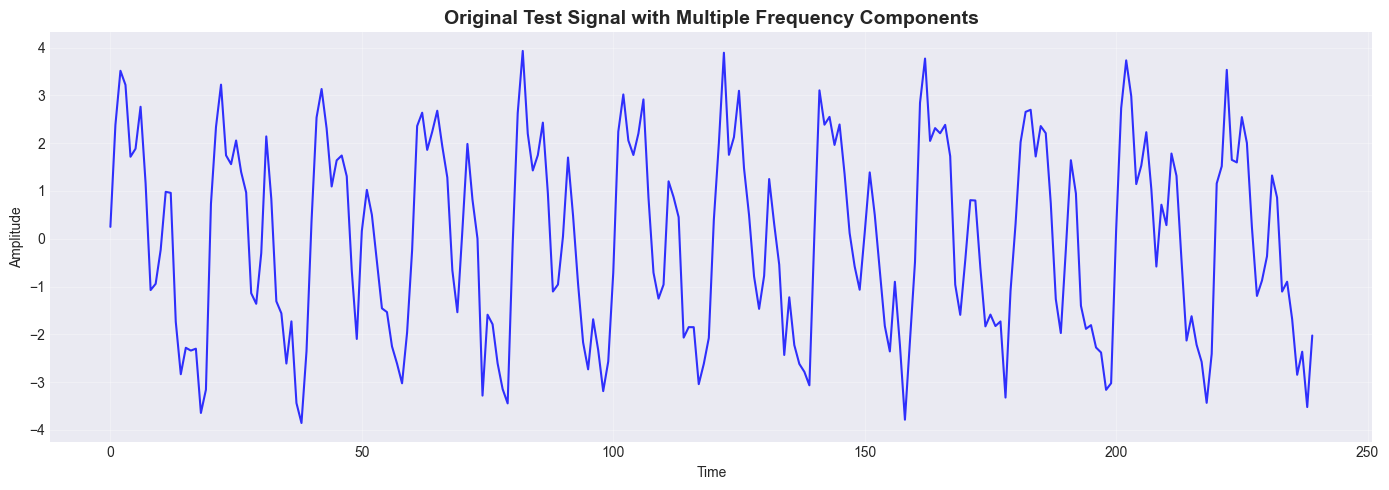

In [3]:
# Create test signal
np.random.seed(42)  # For reproducible results
signal, t = create_test_signal(length=240, fs=1.0)

print(f"Signal created:")
print(f"  - Length: {len(signal)} time points")
print(f"  - Duration: {len(signal)} time units") 
print(f"  - Sampling frequency: 1.0 Hz")
print(f"  - Signal range: [{signal.min():.3f}, {signal.max():.3f}]")

# Plot the original signal
plt.figure(figsize=(14, 5))
plt.plot(t, signal, 'b-', linewidth=1.5, alpha=0.8)
plt.title('Original Test Signal with Multiple Frequency Components', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Apply FITS-based Filter and Plot Results

The FITS filter uses the formula: `cutoff = (seq_len // base_period + 1) * h_order + 10`

For our signal with `seq_len=240`, `base_period=24` (daily cycle), and `h_order=2`:
- Cutoff frequency = (240 // 24 + 1) * 2 + 10 = 11 * 2 + 10 = 32

This preserves the first 32 frequency components and zeros out the rest.

FITS filter applied:
  - Cutoff frequency: 32
  - Filtered signal range: [-3.498, 3.406]


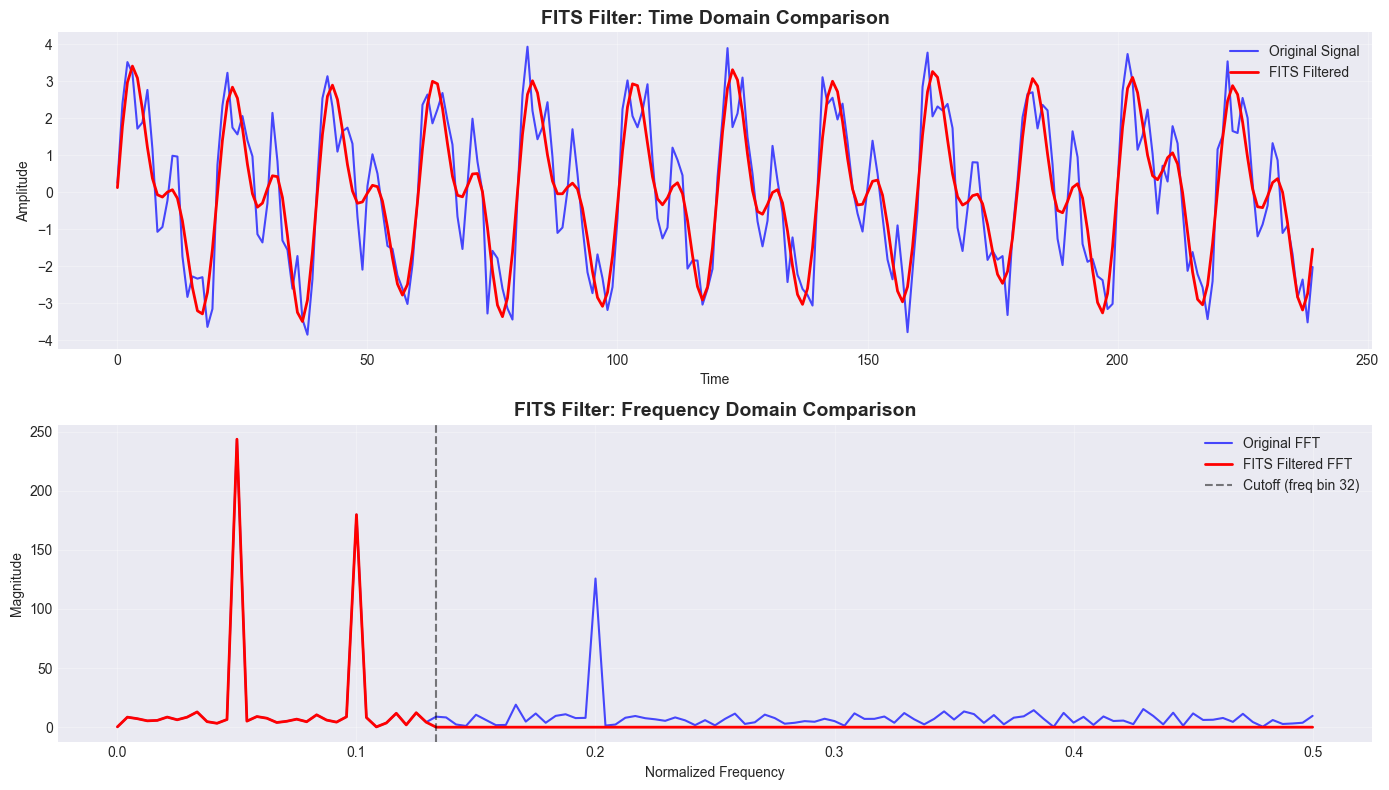

In [4]:
# Apply FITS-based filter
fits_filtered = fits_based_filter(signal, seq_len=len(signal), base_period=24, h_order=2)

print(f"FITS filter applied:")
print(f"  - Cutoff frequency: {(len(signal) // 24 + 1) * 2 + 10}")
print(f"  - Filtered signal range: [{fits_filtered.min():.3f}, {fits_filtered.max():.3f}]")

# Plot original vs FITS filtered
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Time domain comparison
ax1.plot(t, signal, 'b-', linewidth=1.5, alpha=0.7, label='Original Signal')
ax1.plot(t, fits_filtered, 'r-', linewidth=2, label='FITS Filtered')
ax1.set_title('FITS Filter: Time Domain Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Frequency domain comparison
freqs = np.fft.rfftfreq(len(signal))
original_fft = np.abs(np.fft.rfft(signal))
filtered_fft = np.abs(np.fft.rfft(fits_filtered))

ax2.plot(freqs, original_fft, 'b-', linewidth=1.5, alpha=0.7, label='Original FFT')
ax2.plot(freqs, filtered_fft, 'r-', linewidth=2, label='FITS Filtered FFT')
ax2.axvline(x=32/len(signal), color='k', linestyle='--', alpha=0.5, label=f'Cutoff (freq bin 32)')
ax2.set_title('FITS Filter: Frequency Domain Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Normalized Frequency')
ax2.set_ylabel('Magnitude')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Apply Cumulative Power Spectrum Filter and Plot Results

This filter preserves frequencies that contain the most energy. It sorts all frequency components by their power and keeps only those that collectively contain the specified percentage of total energy (default 90%).

Power spectrum filters applied:
  - 90% energy threshold: range [-3.277, 3.187]
  - 80% energy threshold: range [-3.075, 3.057]
  - 95% energy threshold: range [-3.577, 3.374]


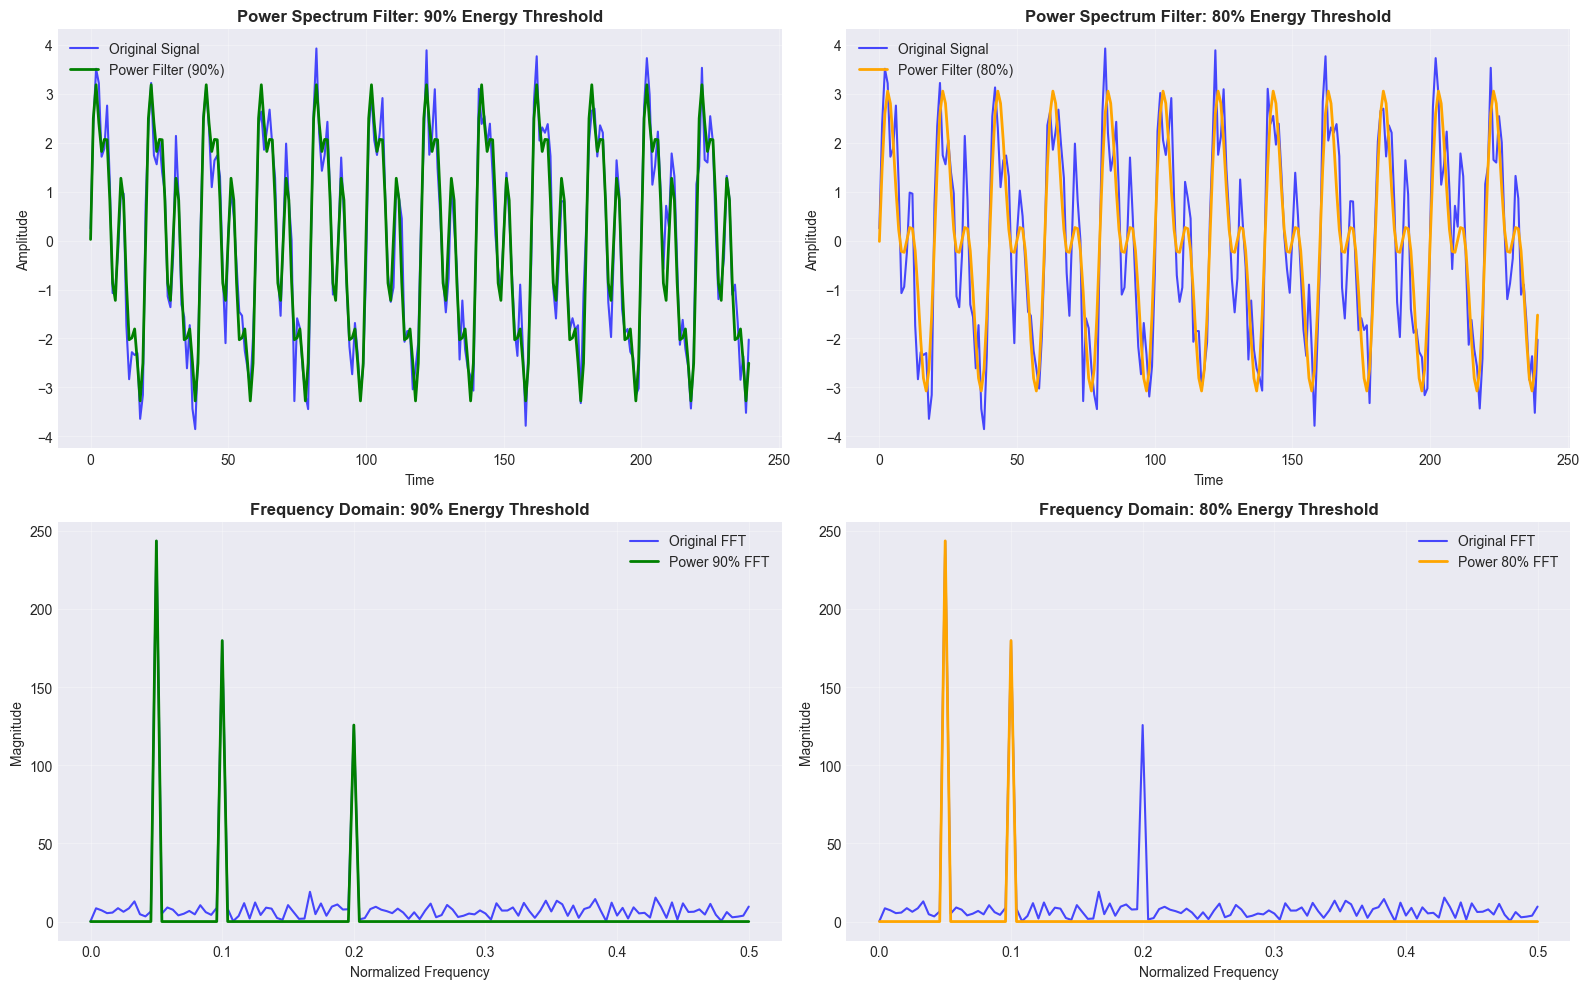

In [5]:
# Apply cumulative power spectrum filter with different thresholds
power_90 = cumulative_power_spectrum_filter(signal, energy_threshold=0.9)
power_80 = cumulative_power_spectrum_filter(signal, energy_threshold=0.8)
power_95 = cumulative_power_spectrum_filter(signal, energy_threshold=0.95)

print(f"Power spectrum filters applied:")
print(f"  - 90% energy threshold: range [{power_90.min():.3f}, {power_90.max():.3f}]")
print(f"  - 80% energy threshold: range [{power_80.min():.3f}, {power_80.max():.3f}]")
print(f"  - 95% energy threshold: range [{power_95.min():.3f}, {power_95.max():.3f}]")

# Plot comparison of different energy thresholds
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Time domain - 90% threshold
ax1.plot(t, signal, 'b-', linewidth=1.5, alpha=0.7, label='Original Signal')
ax1.plot(t, power_90, 'g-', linewidth=2, label='Power Filter (90%)')
ax1.set_title('Power Spectrum Filter: 90% Energy Threshold', fontsize=12, fontweight='bold')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Time domain - 80% threshold
ax2.plot(t, signal, 'b-', linewidth=1.5, alpha=0.7, label='Original Signal')
ax2.plot(t, power_80, 'orange', linewidth=2, label='Power Filter (80%)')
ax2.set_title('Power Spectrum Filter: 80% Energy Threshold', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Frequency domain comparison
freqs = np.fft.rfftfreq(len(signal))
original_fft = np.abs(np.fft.rfft(signal))
power_90_fft = np.abs(np.fft.rfft(power_90))
power_80_fft = np.abs(np.fft.rfft(power_80))

ax3.plot(freqs, original_fft, 'b-', linewidth=1.5, alpha=0.7, label='Original FFT')
ax3.plot(freqs, power_90_fft, 'g-', linewidth=2, label='Power 90% FFT')
ax3.set_title('Frequency Domain: 90% Energy Threshold', fontsize=12, fontweight='bold')
ax3.set_xlabel('Normalized Frequency')
ax3.set_ylabel('Magnitude')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.plot(freqs, original_fft, 'b-', linewidth=1.5, alpha=0.7, label='Original FFT')
ax4.plot(freqs, power_80_fft, 'orange', linewidth=2, label='Power 80% FFT')
ax4.set_title('Frequency Domain: 80% Energy Threshold', fontsize=12, fontweight='bold')
ax4.set_xlabel('Normalized Frequency')
ax4.set_ylabel('Magnitude')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Compare All Filters Side by Side

Let's create a comprehensive comparison showing the original signal and both filtering approaches to see their relative effects.

## Analyze Frequency Domain Effects

Let's take a closer look at how each filter affects specific frequency components and understand the filtering behavior in detail.

FITS Filter Analysis:
  - Cutoff frequency bin: 32
  - Cutoff frequency: 0.1333 (normalized)
  - Frequencies preserved: 32/121 (26.4%)

Power Filter Analysis:
  - Frequencies preserved: 3/121 (2.5%)
  - Energy preserved: 94.1%


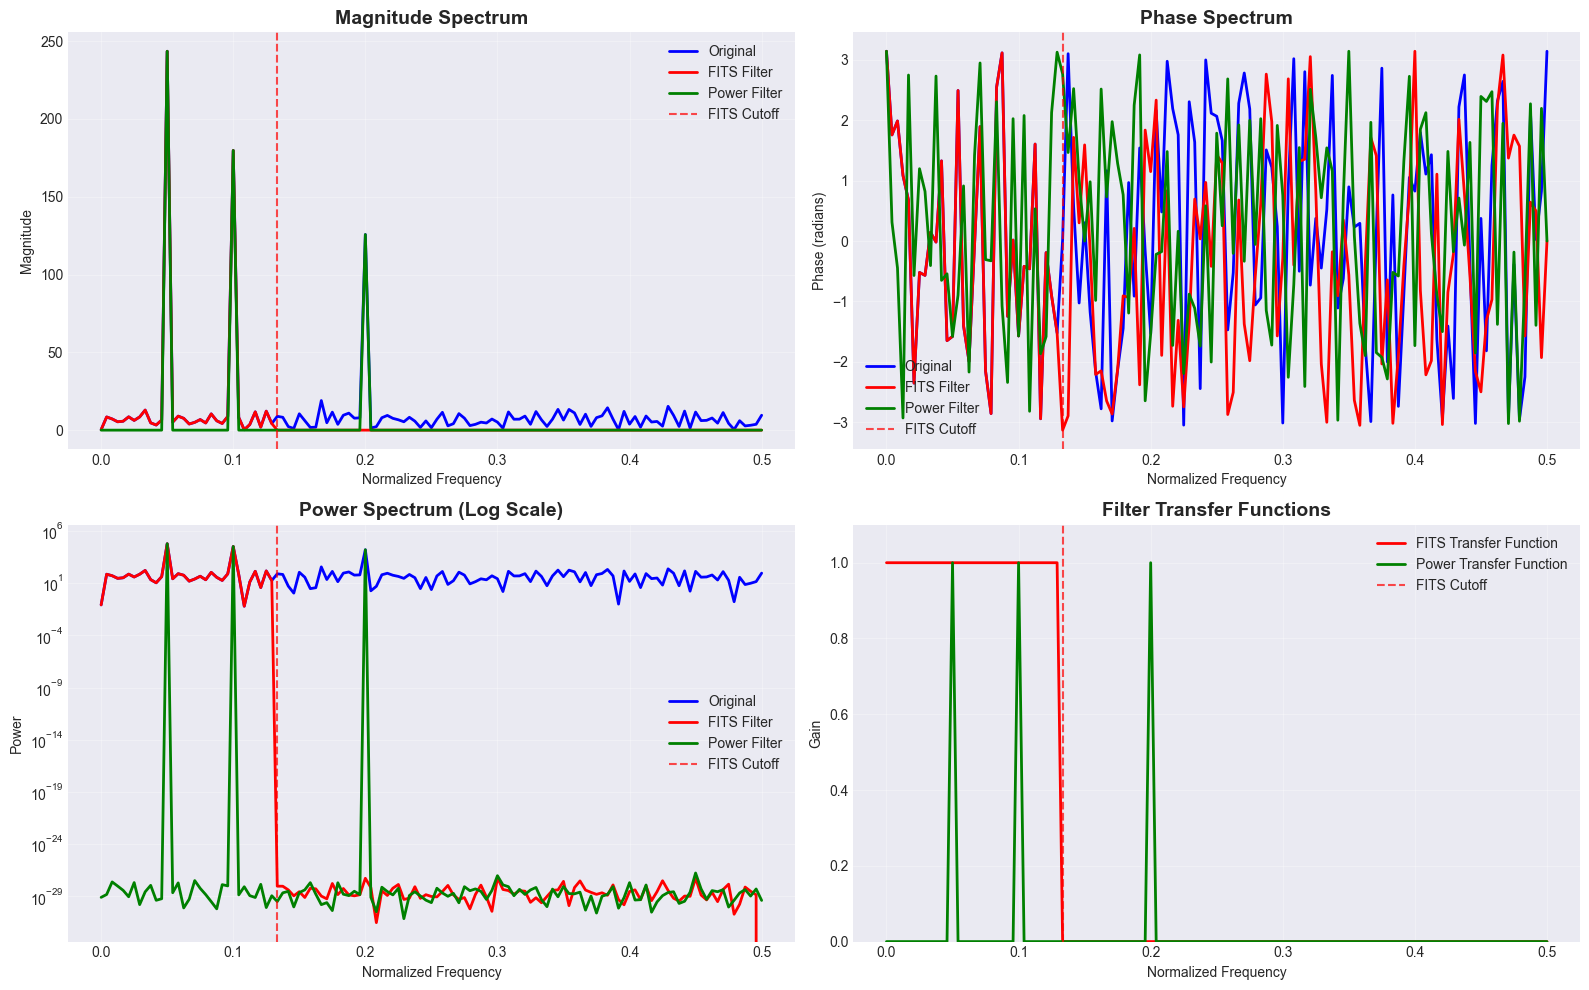


Top 10 Frequency Components:
Rank  Freq Bin Frequency    Power        FITS     Power Filter
----------------------------------------------------------------------
1     12       0.0500       59280.29     ✓        ✓           
2     24       0.1000       32295.72     ✓        ✓           
3     48       0.2000       15799.68     ✗        ✓           
4     40       0.1667       361.86       ✗        ✗           
5     103      0.4292       234.44       ✗        ✗           
6     92       0.3833       206.55       ✗        ✗           
7     83       0.3458       178.14       ✗        ✗           
8     85       0.3542       176.76       ✗        ✗           
9     8        0.0333       166.32       ✓        ✗           
10    106      0.4417       149.70       ✗        ✗           


In [6]:
# Detailed frequency analysis
freqs = np.fft.rfftfreq(len(signal))
original_fft = np.fft.rfft(signal)
fits_fft = np.fft.rfft(fits_filtered)
power_fft = np.fft.rfft(power_90)

# Calculate power spectra
original_power = np.abs(original_fft)**2
fits_power = np.abs(fits_fft)**2
power_90_power = np.abs(power_fft)**2

# Analyze which frequencies are preserved/removed
fits_cutoff = int((len(signal) // 24 + 1) * 2 + 10)
print(f"FITS Filter Analysis:")
print(f"  - Cutoff frequency bin: {fits_cutoff}")
print(f"  - Cutoff frequency: {freqs[fits_cutoff]:.4f} (normalized)")
print(f"  - Frequencies preserved: {fits_cutoff}/{len(freqs)} ({100*fits_cutoff/len(freqs):.1f}%)")

# Find which frequencies the power filter preserved
power_mask = np.abs(power_fft) > 1e-10  # Threshold for "preserved"
power_preserved = np.sum(power_mask)
print(f"\nPower Filter Analysis:")
print(f"  - Frequencies preserved: {power_preserved}/{len(freqs)} ({100*power_preserved/len(freqs):.1f}%)")
print(f"  - Energy preserved: {np.sum(power_90_power)/np.sum(original_power):.1%}")

# Detailed frequency domain plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Magnitude spectrum
ax1.plot(freqs, np.abs(original_fft), 'b-', linewidth=2, label='Original')
ax1.plot(freqs, np.abs(fits_fft), 'r-', linewidth=2, label='FITS Filter')
ax1.plot(freqs, np.abs(power_fft), 'g-', linewidth=2, label='Power Filter')
ax1.axvline(x=freqs[fits_cutoff], color='r', linestyle='--', alpha=0.7, label=f'FITS Cutoff')
ax1.set_title('Magnitude Spectrum', fontsize=14, fontweight='bold')
ax1.set_xlabel('Normalized Frequency')
ax1.set_ylabel('Magnitude')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Phase spectrum
ax2.plot(freqs, np.angle(original_fft), 'b-', linewidth=2, label='Original')
ax2.plot(freqs, np.angle(fits_fft), 'r-', linewidth=2, label='FITS Filter')
ax2.plot(freqs, np.angle(power_fft), 'g-', linewidth=2, label='Power Filter')
ax2.axvline(x=freqs[fits_cutoff], color='r', linestyle='--', alpha=0.7, label=f'FITS Cutoff')
ax2.set_title('Phase Spectrum', fontsize=14, fontweight='bold')
ax2.set_xlabel('Normalized Frequency')
ax2.set_ylabel('Phase (radians)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Power spectrum
ax3.semilogy(freqs, original_power, 'b-', linewidth=2, label='Original')
ax3.semilogy(freqs, fits_power, 'r-', linewidth=2, label='FITS Filter')
ax3.semilogy(freqs, power_90_power, 'g-', linewidth=2, label='Power Filter')
ax3.axvline(x=freqs[fits_cutoff], color='r', linestyle='--', alpha=0.7, label=f'FITS Cutoff')
ax3.set_title('Power Spectrum (Log Scale)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Normalized Frequency')
ax3.set_ylabel('Power')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Filter transfer functions
fits_transfer = np.abs(fits_fft) / np.abs(original_fft)
power_transfer = np.abs(power_fft) / np.abs(original_fft)

# Handle division by zero
fits_transfer[np.abs(original_fft) < 1e-10] = 0
power_transfer[np.abs(original_fft) < 1e-10] = 0

ax4.plot(freqs, fits_transfer, 'r-', linewidth=2, label='FITS Transfer Function')
ax4.plot(freqs, power_transfer, 'g-', linewidth=2, label='Power Transfer Function')
ax4.axvline(x=freqs[fits_cutoff], color='r', linestyle='--', alpha=0.7, label=f'FITS Cutoff')
ax4.set_title('Filter Transfer Functions', fontsize=14, fontweight='bold')
ax4.set_xlabel('Normalized Frequency')
ax4.set_ylabel('Gain')
ax4.set_ylim(0, 1.1)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find the dominant frequency components
peak_indices = np.argsort(original_power)[-10:][::-1]  # Top 10 peaks
print(f"\nTop 10 Frequency Components:")
print(f"{'Rank':<5} {'Freq Bin':<8} {'Frequency':<12} {'Power':<12} {'FITS':<8} {'Power Filter':<12}")
print("-"*70)
for i, idx in enumerate(peak_indices):
    fits_preserved = "✓" if idx < fits_cutoff else "✗"
    power_preserved = "✓" if power_mask[idx] else "✗"
    print(f"{i+1:<5} {idx:<8} {freqs[idx]:<12.4f} {original_power[idx]:<12.2f} {fits_preserved:<8} {power_preserved:<12}")

## Test Filters on Different Signal Types

Let's test our filters on different types of time series patterns to see how they perform across various scenarios:

1. **Seasonal pattern** - Regular periodic behavior
2. **Trending data** - Long-term trend with noise
3. **Noisy signal** - High-frequency noise on top of slow variation

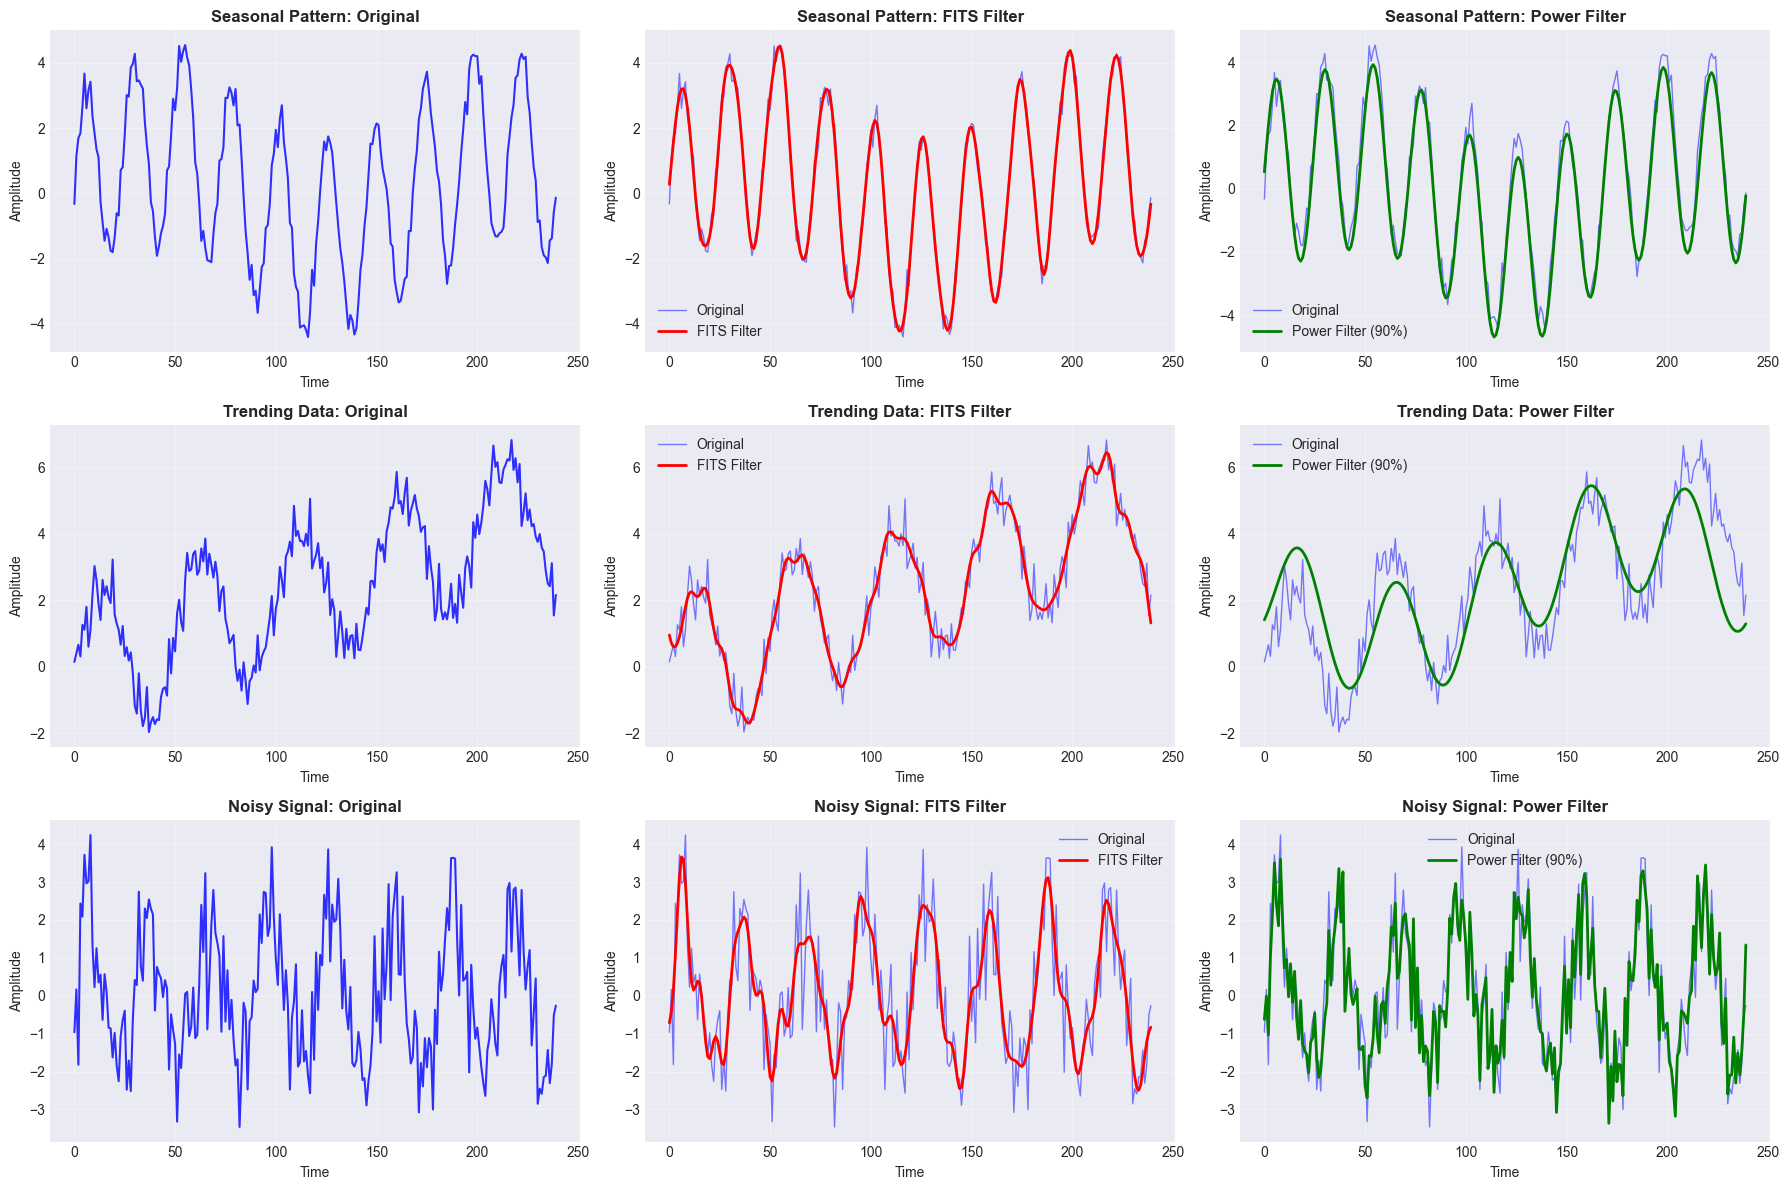

FILTER EFFECTIVENESS ANALYSIS

Seasonal Pattern:
  Standard Deviation:
    Original: 2.3335
    FITS:     2.3192 (+0.6%)
    Power:    2.3058 (+1.2%)
  Smoothness (lower = smoother):
    Original: 0.5864
    FITS:     0.1309 (+77.7%)
    Power:    0.1275 (+78.3%)

Trending Data:
  Standard Deviation:
    Original: 1.9861
    FITS:     1.9389 (+2.4%)
    Power:    1.6511 (+16.9%)
  Smoothness (lower = smoother):
    Original: 0.9482
    FITS:     0.0540 (+94.3%)
    Power:    0.0187 (+98.0%)

Noisy Signal:
  Standard Deviation:
    Original: 1.7059
    FITS:     1.4879 (+12.8%)
    Power:    1.6186 (+5.1%)
  Smoothness (lower = smoother):
    Original: 1.9231
    FITS:     0.1427 (+92.6%)
    Power:    1.5960 (+17.0%)


In [7]:
# Create different types of test signals
np.random.seed(123)
length = 240
t = np.arange(length)

# 1. Seasonal pattern (daily + weekly cycles)
seasonal = (3.0 * np.sin(2 * np.pi * t / 24) +     # Daily cycle
           1.5 * np.sin(2 * np.pi * t / (24*7)) +   # Weekly cycle
           0.3 * np.random.randn(length))            # Small noise

# 2. Trending data
trend = 0.02 * t + 2.0 * np.sin(2 * np.pi * t / 50) + 0.5 * np.random.randn(length)

# 3. Noisy signal
clean_signal = 2.0 * np.sin(2 * np.pi * t / 30)
noisy = clean_signal + 1.0 * np.random.randn(length)

# Apply filters to each signal type
signals = [seasonal, trend, noisy]
signal_names = ['Seasonal Pattern', 'Trending Data', 'Noisy Signal']

# Create plots for each signal type
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, (sig, name) in enumerate(zip(signals, signal_names)):
    # Apply filters
    fits_filt = fits_based_filter(sig, seq_len=len(sig), base_period=24, h_order=2)
    power_filt = cumulative_power_spectrum_filter(sig, energy_threshold=0.9)
    
    # Plot original signal
    axes[i, 0].plot(t, sig, 'b-', linewidth=1.5, alpha=0.8)
    axes[i, 0].set_title(f'{name}: Original', fontsize=12, fontweight='bold')
    axes[i, 0].set_xlabel('Time')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Plot FITS filtered
    axes[i, 1].plot(t, sig, 'b-', linewidth=1, alpha=0.5, label='Original')
    axes[i, 1].plot(t, fits_filt, 'r-', linewidth=2, label='FITS Filter')
    axes[i, 1].set_title(f'{name}: FITS Filter', fontsize=12, fontweight='bold')
    axes[i, 1].set_xlabel('Time')
    axes[i, 1].set_ylabel('Amplitude')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)
    
    # Plot Power filtered
    axes[i, 2].plot(t, sig, 'b-', linewidth=1, alpha=0.5, label='Original')
    axes[i, 2].plot(t, power_filt, 'g-', linewidth=2, label='Power Filter (90%)')
    axes[i, 2].set_title(f'{name}: Power Filter', fontsize=12, fontweight='bold')
    axes[i, 2].set_xlabel('Time')
    axes[i, 2].set_ylabel('Amplitude')
    axes[i, 2].legend()
    axes[i, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quantitative analysis
print("FILTER EFFECTIVENESS ANALYSIS")
print("="*80)
for i, (sig, name) in enumerate(zip(signals, signal_names)):
    fits_filt = fits_based_filter(sig, seq_len=len(sig), base_period=24, h_order=2)
    power_filt = cumulative_power_spectrum_filter(sig, energy_threshold=0.9)
    
    # Calculate noise reduction (assuming high-frequency = noise)
    orig_std = np.std(sig)
    fits_std = np.std(fits_filt)
    power_std = np.std(power_filt)
    
    # Calculate smoothness (second derivative)
    orig_smooth = np.mean(np.abs(np.diff(sig, n=2)))
    fits_smooth = np.mean(np.abs(np.diff(fits_filt, n=2)))
    power_smooth = np.mean(np.abs(np.diff(power_filt, n=2)))
    
    print(f"\n{name}:")
    print(f"  Standard Deviation:")
    print(f"    Original: {orig_std:.4f}")
    print(f"    FITS:     {fits_std:.4f} ({100*(orig_std-fits_std)/orig_std:+.1f}%)")
    print(f"    Power:    {power_std:.4f} ({100*(orig_std-power_std)/orig_std:+.1f}%)")
    print(f"  Smoothness (lower = smoother):")
    print(f"    Original: {orig_smooth:.4f}")
    print(f"    FITS:     {fits_smooth:.4f} ({100*(orig_smooth-fits_smooth)/orig_smooth:+.1f}%)")
    print(f"    Power:    {power_smooth:.4f} ({100*(orig_smooth-power_smooth)/orig_smooth:+.1f}%)")

## Summary and Conclusions

### Key Findings:

1. **FITS Filter**: 
   - Uses a fixed cutoff based on sequence length and base period
   - Provides consistent, predictable filtering behavior
   - Good for preserving structured patterns (daily, weekly cycles)

2. **Power Spectrum Filter**:
   - Adaptive approach that preserves the most energetic frequency components
   - Better at preserving signal content while removing noise
   - More flexible but less predictable

3. **Trade-offs**:
   - FITS filter is more systematic and reproducible
   - Power filter is more adaptive to signal characteristics
   - Both significantly reduce high-frequency noise while preserving main patterns

### Usage Recommendations:

- **Use FITS filter** when you want consistent behavior across different datasets
- **Use Power filter** when signal characteristics vary significantly between datasets
- Consider the `base_period` parameter carefully based on your data's natural cycles (hourly=24, daily=7, etc.)

## FITS → CPS Pipeline Filter

We now combine both approaches:
- First apply the FITS-style low-pass (which determines a cutoff from sequence length and base period)
- Measure how much energy the FITS filter preserves
- Use that energy ratio as the target for the Cumulative Power Spectrum (CPS) filter

This gives an adaptive CPS threshold grounded in the FITS cutoff rather than a fixed value like 0.9.

FITS → CPS pipeline applied:
  - FITS cut_freq: 32
  - Derived energy_threshold for CPS: 0.8158


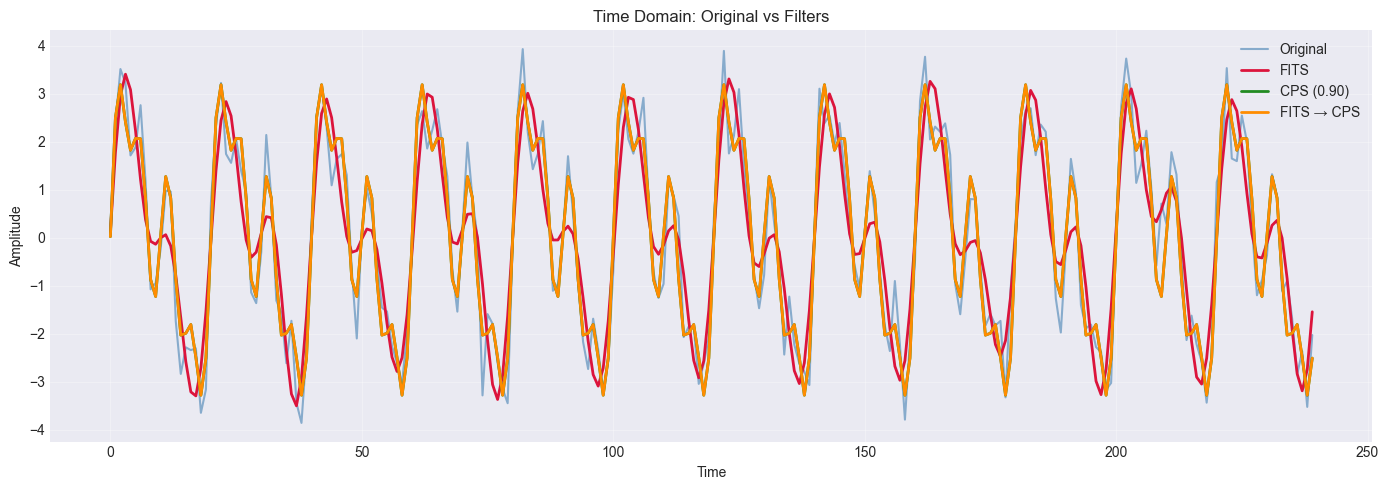

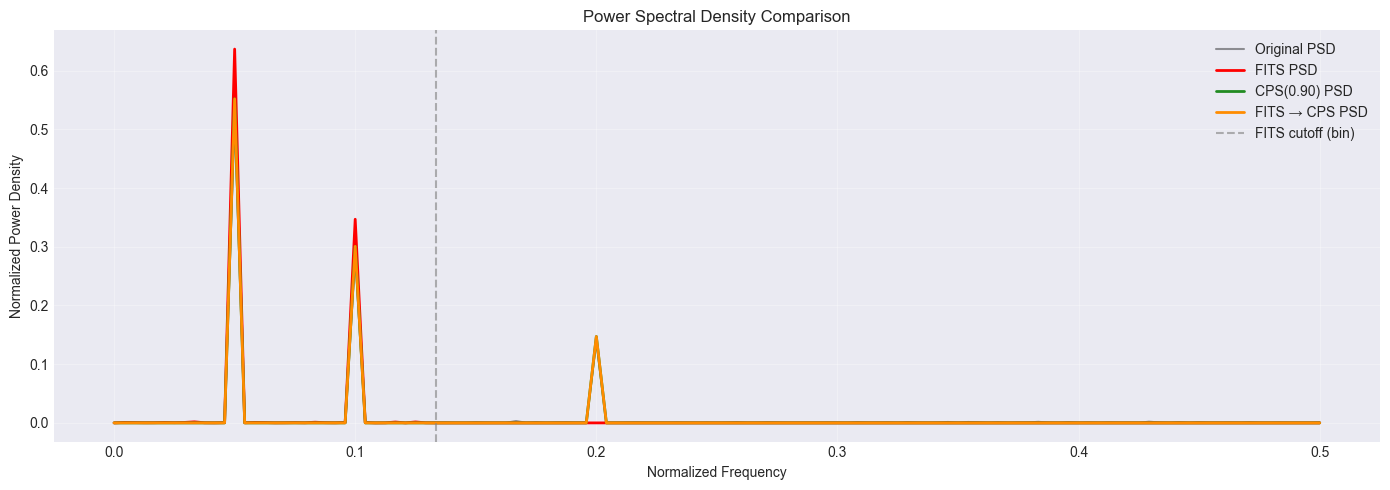


QUANTITATIVE SUMMARY
---------------------
Original   std=1.9901  energy=114108.67
FITS       std=1.7978  energy=93088.72
CPS_0.90   std=1.9309  energy=107375.69
FITS→CPS   std=1.9309  energy=107375.69


In [8]:
# Compute FITS → CPS pipeline output and compare

# Import the implementation from lag-llama/data/data_utils
import sys, os
# sys.path.append(os.path.join(os.path.dirname('.'), 'lag-llama'))
from simple_filter_test import fits_then_cps_filter


pipeline_filtered, info = fits_then_cps_filter(
    signal,
    seq_len=len(signal),
    base_period=24,
    h_order=2,
    return_info=True,
)

print("FITS → CPS pipeline applied:")
print(f"  - FITS cut_freq: {info['cut_freq']}")
print(f"  - Derived energy_threshold for CPS: {info['energy_threshold']:.4f}")

# Baselines already computed earlier: fits_filtered and power_90

# 1) Time-domain comparison
plt.figure(figsize=(14, 5))
plt.plot(t, signal, color='steelblue', alpha=0.6, label='Original')
plt.plot(t, fits_filtered, color='crimson', linewidth=2, label='FITS')
plt.plot(t, power_90, color='forestgreen', linewidth=2, label='CPS (0.90)')
plt.plot(t, pipeline_filtered, color='darkorange', linewidth=2, label='FITS → CPS')
plt.title('Time Domain: Original vs Filters')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) PSD comparison
freqs = np.fft.rfftfreq(len(signal))
orig_pow = np.abs(np.fft.rfft(signal))**2
fits_pow = np.abs(np.fft.rfft(fits_filtered))**2
cps90_pow = np.abs(np.fft.rfft(power_90))**2
pipe_pow = np.abs(np.fft.rfft(pipeline_filtered))**2

# Normalize to densities
orig_psd = orig_pow / np.sum(orig_pow)
fits_psd = fits_pow / np.sum(fits_pow)
cps90_psd = cps90_pow / np.sum(cps90_pow)
pipe_psd = pipe_pow / np.sum(pipe_pow)

plt.figure(figsize=(14, 5))
plt.plot(freqs, orig_psd, 'k-', alpha=0.4, label='Original PSD')
plt.plot(freqs, fits_psd, 'r-', linewidth=2, label='FITS PSD')
plt.plot(freqs, cps90_psd, color='forestgreen', linewidth=2, label='CPS(0.90) PSD')
plt.plot(freqs, pipe_psd, color='darkorange', linewidth=2, label='FITS → CPS PSD')
plt.axvline(x=info['cut_freq']/len(signal), color='gray', linestyle='--', alpha=0.6, label='FITS cutoff (bin)')
plt.title('Power Spectral Density Comparison')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Power Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Quick quantitative comparison
metrics = {
    'Original': {
        'std': float(np.std(signal)),
        'energy': float(np.sum(orig_pow))
    },
    'FITS': {
        'std': float(np.std(fits_filtered)),
        'energy': float(np.sum(fits_pow))
    },
    'CPS_0.90': {
        'std': float(np.std(power_90)),
        'energy': float(np.sum(cps90_pow))
    },
    'FITS→CPS': {
        'std': float(np.std(pipeline_filtered)),
        'energy': float(np.sum(pipe_pow))
    }
}

print("\nQUANTITATIVE SUMMARY")
print("---------------------")
for k, v in metrics.items():
    print(f"{k:<10} std={v['std']:.4f}  energy={v['energy']:.2f}")

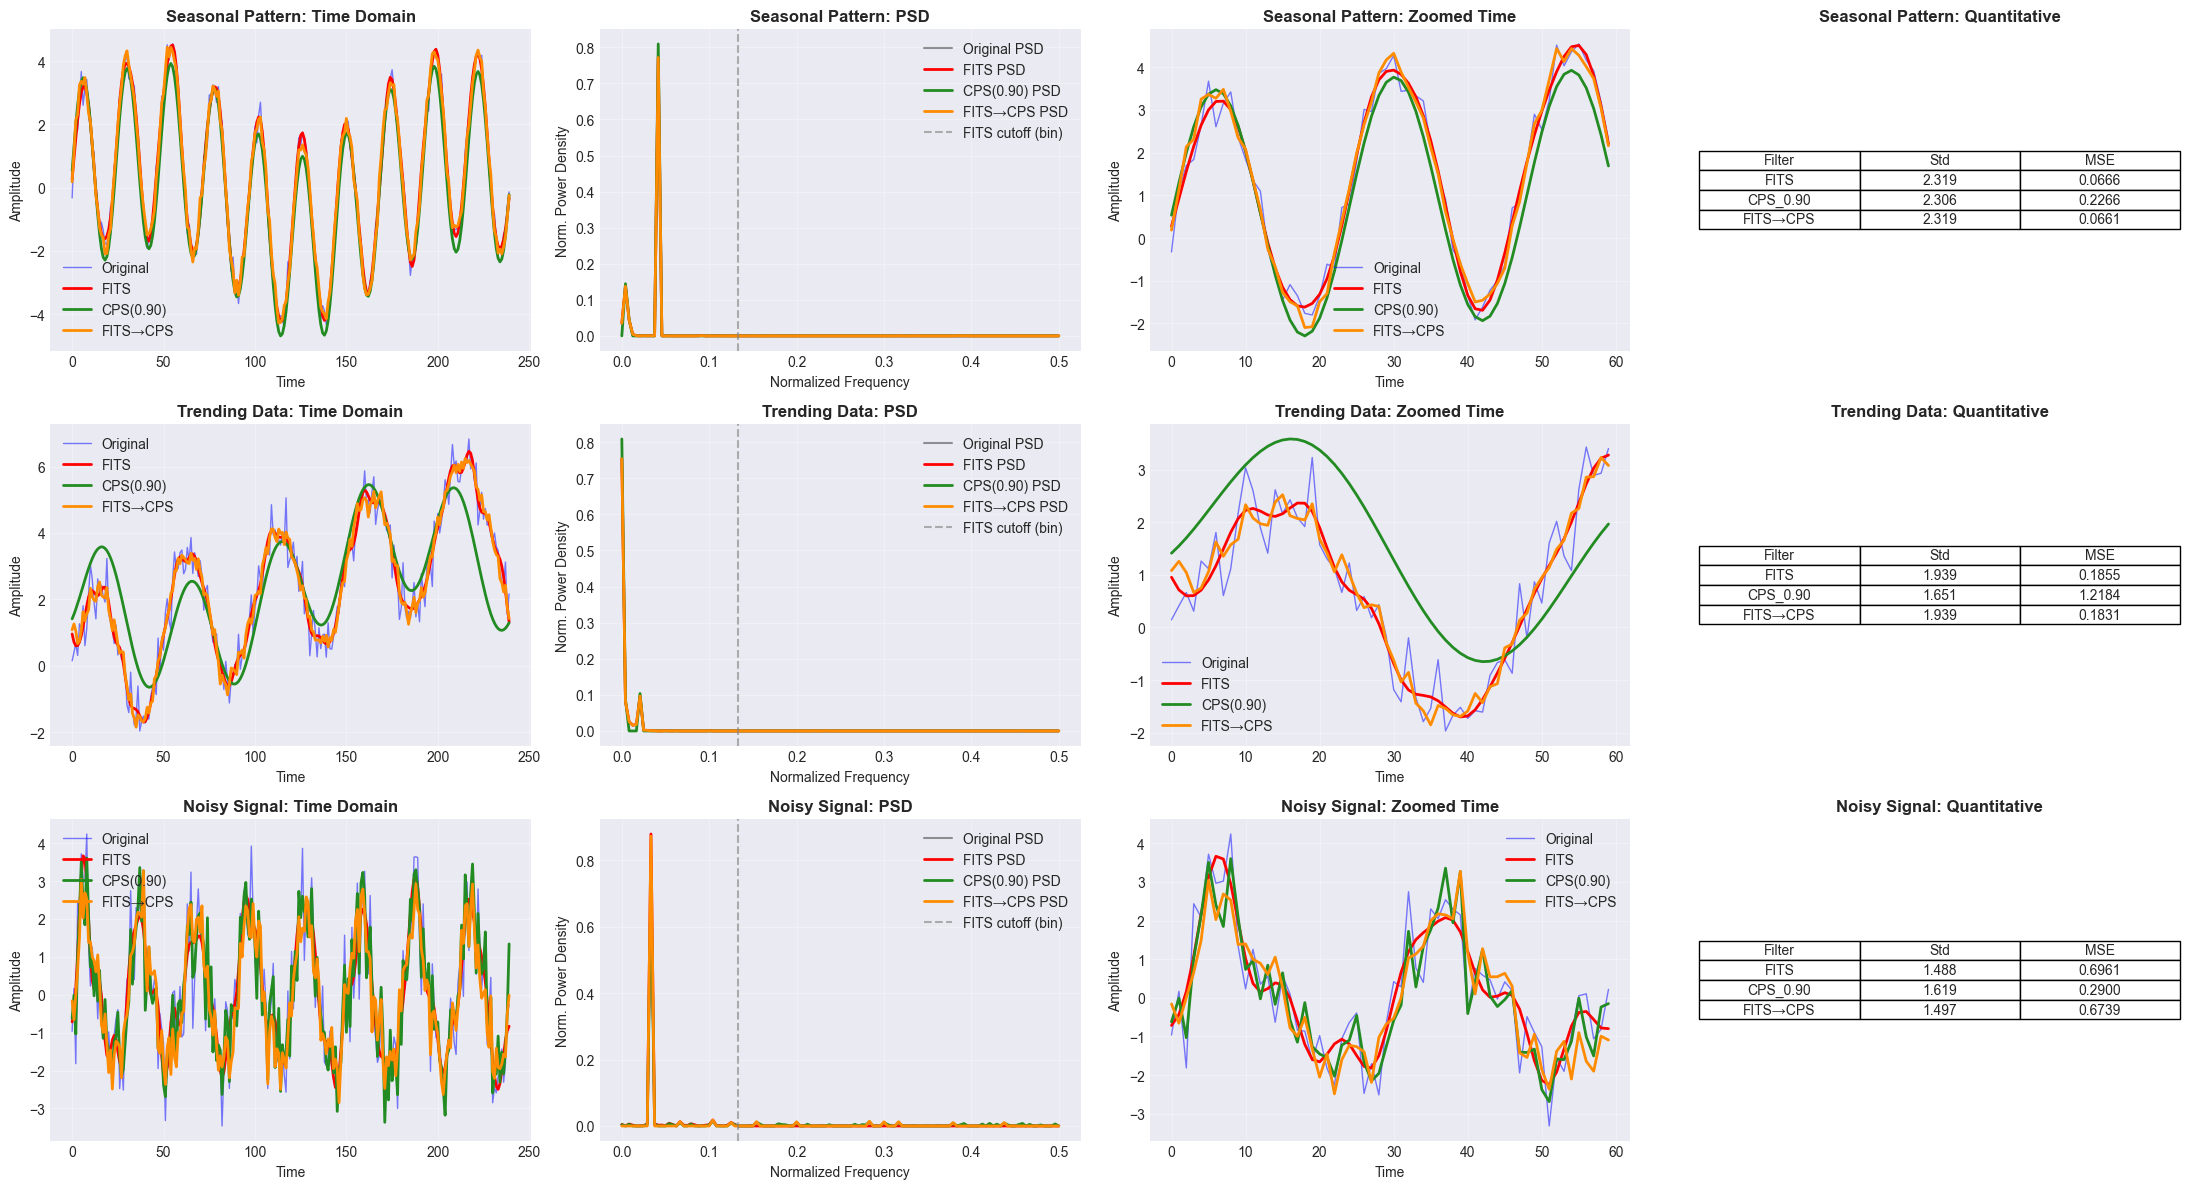


QUANTITATIVE SUMMARY (all signals)

Seasonal Pattern:
  FITS       std=2.3192  mse=0.0666
  CPS_0.90   std=2.3058  mse=0.2266
  FITS→CPS   std=2.3193  mse=0.0661  (CPS_thresh=0.9880, FITS_cut=32)

Trending Data:
  FITS       std=1.9389  mse=0.1855
  CPS_0.90   std=1.6511  mse=1.2184
  FITS→CPS   std=1.9395  mse=0.1831  (CPS_thresh=0.9880, FITS_cut=32)

Noisy Signal:
  FITS       std=1.4879  mse=0.6961
  CPS_0.90   std=1.6186  mse=0.2900
  FITS→CPS   std=1.4971  mse=0.6739  (CPS_thresh=0.7616, FITS_cut=32)


In [9]:
# Compare FITS, CPS(0.90), and FITS→CPS pipeline for all signal types
from simple_filter_test import fits_then_cps_filter

np.random.seed(123)
length = 240
t = np.arange(length)
signals = [seasonal, trend, noisy]
signal_names = ['Seasonal Pattern', 'Trending Data', 'Noisy Signal']

fig, axes = plt.subplots(3, 4, figsize=(22, 12))

quant_summary = []

for i, (sig, name) in enumerate(zip(signals, signal_names)):
    # FITS
    fits_filt = fits_based_filter(sig, seq_len=len(sig), base_period=24, h_order=2)
    # CPS(0.90)
    cps_filt = cumulative_power_spectrum_filter(sig, energy_threshold=0.9)
    # FITS→CPS pipeline
    pipe_filt, info = fits_then_cps_filter(sig, seq_len=len(sig), base_period=24, h_order=2, return_info=True)

    # Time domain
    axes[i, 0].plot(t, sig, 'b-', linewidth=1, alpha=0.5, label='Original')
    axes[i, 0].plot(t, fits_filt, 'r-', linewidth=2, label='FITS')
    axes[i, 0].plot(t, cps_filt, color='forestgreen', linewidth=2, label='CPS(0.90)')
    axes[i, 0].plot(t, pipe_filt, color='darkorange', linewidth=2, label='FITS→CPS')
    axes[i, 0].set_title(f'{name}: Time Domain', fontsize=12, fontweight='bold')
    axes[i, 0].set_xlabel('Time')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)

    # PSDs
    freqs = np.fft.rfftfreq(len(sig))
    orig_pow = np.abs(np.fft.rfft(sig))**2
    fits_pow = np.abs(np.fft.rfft(fits_filt))**2
    cps_pow = np.abs(np.fft.rfft(cps_filt))**2
    pipe_pow = np.abs(np.fft.rfft(pipe_filt))**2
    orig_psd = orig_pow / np.sum(orig_pow)
    fits_psd = fits_pow / np.sum(fits_pow)
    cps_psd = cps_pow / np.sum(cps_pow)
    pipe_psd = pipe_pow / np.sum(pipe_pow)

    axes[i, 1].plot(freqs, orig_psd, 'k-', alpha=0.4, label='Original PSD')
    axes[i, 1].plot(freqs, fits_psd, 'r-', linewidth=2, label='FITS PSD')
    axes[i, 1].plot(freqs, cps_psd, color='forestgreen', linewidth=2, label='CPS(0.90) PSD')
    axes[i, 1].plot(freqs, pipe_psd, color='darkorange', linewidth=2, label='FITS→CPS PSD')
    axes[i, 1].axvline(x=info['cut_freq']/len(sig), color='gray', linestyle='--', alpha=0.6, label='FITS cutoff (bin)')
    axes[i, 1].set_title(f'{name}: PSD', fontsize=12, fontweight='bold')
    axes[i, 1].set_xlabel('Normalized Frequency')
    axes[i, 1].set_ylabel('Norm. Power Density')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

    # Zoomed-in time domain (first 60 points)
    axes[i, 2].plot(t[:60], sig[:60], 'b-', linewidth=1, alpha=0.5, label='Original')
    axes[i, 2].plot(t[:60], fits_filt[:60], 'r-', linewidth=2, label='FITS')
    axes[i, 2].plot(t[:60], cps_filt[:60], color='forestgreen', linewidth=2, label='CPS(0.90)')
    axes[i, 2].plot(t[:60], pipe_filt[:60], color='darkorange', linewidth=2, label='FITS→CPS')
    axes[i, 2].set_title(f'{name}: Zoomed Time', fontsize=12, fontweight='bold')
    axes[i, 2].set_xlabel('Time')
    axes[i, 2].set_ylabel('Amplitude')
    axes[i, 2].legend()
    axes[i, 2].grid(True, alpha=0.3)

    # Quantitative summary (MSE to original)
    mse_fits = np.mean((sig - fits_filt) ** 2)
    mse_cps = np.mean((sig - cps_filt) ** 2)
    mse_pipe = np.mean((sig - pipe_filt) ** 2)
    metrics = {
        'FITS': {
            'std': float(np.std(fits_filt)),
            'mse': float(mse_fits)
        },
        'CPS_0.90': {
            'std': float(np.std(cps_filt)),
            'mse': float(mse_cps)
        },
        'FITS→CPS': {
            'std': float(np.std(pipe_filt)),
            'mse': float(mse_pipe),
            'cps_energy_thresh': info['energy_threshold'],
            'fits_cut_freq': info['cut_freq']
        }
    }
    quant_summary.append((name, metrics))

    # Table in subplot
    table_data = [
        [k, f"{v['std']:.3f}", f"{v['mse']:.4f}"] for k, v in metrics.items()
    ]
    col_labels = ['Filter', 'Std', 'MSE']
    axes[i, 3].axis('off')
    axes[i, 3].table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
    axes[i, 3].set_title(f'{name}: Quantitative', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary table
print("\nQUANTITATIVE SUMMARY (all signals)")
print("="*60)
for name, metrics in quant_summary:
    print(f"\n{name}:")
    for k, v in metrics.items():
        if k == 'FITS→CPS':
            print(f"  {k:<10} std={v['std']:.4f}  mse={v['mse']:.4f}  (CPS_thresh={v['cps_energy_thresh']:.4f}, FITS_cut={v['fits_cut_freq']})")
        else:
            print(f"  {k:<10} std={v['std']:.4f}  mse={v['mse']:.4f}")